In [1]:
### If save data:
save_data =  False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "Figs/"
  ensure_dir(save_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import os

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim

import urllib.request
dir_phase = os.path.join(os.getcwd(),'phase_diagram_data.npz')
url = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/phase_diagram_data.npz"
urllib.request.urlretrieve(url, dir_phase)

('/content/phase_diagram_data.npz',
 <http.client.HTTPMessage at 0x7f491a4a0400>)

In [3]:
def perceptron_expt(pvals, N, lamb = 0.25, sigma = 0, num_repeats=5, dN = 0):
  errs = np.zeros((len(pvals), num_repeats))
  key = random.PRNGKey(1)
  w_teach = 1/np.sqrt(N) * random.normal(key, (N + dN,)) # You can also average over this. 
  for i,p in enumerate(pvals):
    for j in range(num_repeats):
      key, teach, train, test, noise = random.split(key, 5)
      X_tr = random.normal(train, (p, N+dN))
      X_te = random.normal(test, (5000, N + dN))
      y = X_tr @ w_teach + sigma * random.normal(noise, (p,)) 
      y_true = X_te @ w_teach
      X_tr = X_tr[:,0:N]
      X_te = X_te[:,0:N]
      if lamb == 0:
        if p < N:
          yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T) @ y
        else:
          yhat = X_te @ jnp.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y
      else:
        yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T + N*lamb*jnp.eye(p)) @ y

      errs[i,j] = np.mean((yhat - y_true)**2)
  return errs

def theory(alpha, sigma, lamb, out_var=0):
  z = 0.5 * ( 1+lamb - alpha + np.sqrt( (1+lamb - alpha)**2 + 4*lamb*alpha ) )
  return (z**2 + (sigma**2 + out_var) * alpha) / ( (alpha+z)**2 - alpha ) + out_var



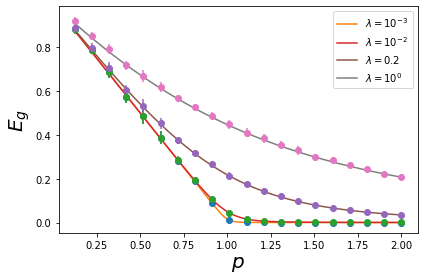

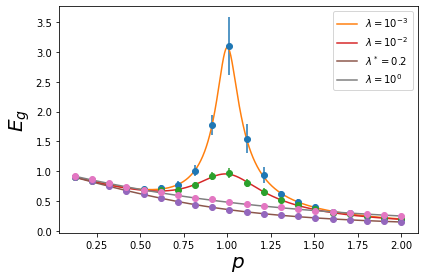

In [4]:
lamb_vals = [1e-3,1e-2,0.2,1]
N = 800
pvals = np.linspace(100,2*N,num = 20).astype('int')
ptheory = np.linspace(100, 2*N, num = 1000)
sigma = 0
num_repeats = 15

no_noise_expt = []
no_noise_std = []
no_noise_theory = []
for i, lamb in enumerate(lamb_vals):
  expt = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=num_repeats)
  errs = expt.mean(axis=1)
  stds = expt.std(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  no_noise_expt += [errs]
  no_noise_std += [stds]
  no_noise_theory += [theory_errs]

for i, lamb in enumerate(lamb_vals):
  plt.errorbar(pvals/N, no_noise_expt[i], no_noise_std[i], fmt='o')
  if lamb == 0.2:
    plt.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = %0.1f$' % lamb )
  else:
    plt.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)) )
plt.legend()
plt.xlabel(r'$p$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.tight_layout()
plt.show()

# make noise nonzero
sigma = np.sqrt(0.2)

reg_noise_expt = []
reg_noise_std = []
reg_noise_theory = []
for i, lamb in enumerate(lamb_vals):
  expt = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats = num_repeats)
  errs = expt.mean(axis=1)
  stds = expt.std(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  reg_noise_expt += [errs]
  reg_noise_std += [stds]
  reg_noise_theory += [theory_errs]

for i, lamb in enumerate(lamb_vals):
  plt.errorbar(pvals/N, reg_noise_expt[i], reg_noise_std[i], fmt='o')
  if lamb == 0.2:
    plt.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda^*  = %0.1f$' % lamb)
  else:
    plt.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)) )

plt.legend()
plt.xlabel(r'$p$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.tight_layout()
plt.show()

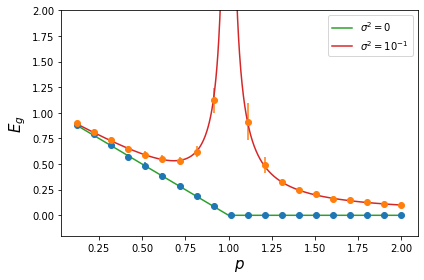

In [5]:
sigmavals = [0,np.sqrt(1e-1)]
lamb = 0
no_reg_expt = []
no_reg_std = []
no_reg_theory = []
for i, sigma in enumerate(sigmavals):
  expt = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats = num_repeats)
  errs = expt.mean(axis=1)
  stds = expt.std(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  no_reg_expt += [errs]
  no_reg_std += [stds]
  no_reg_theory += [theory_errs]

for i, sigma in enumerate(sigmavals):
  plt.errorbar(pvals/N, no_reg_expt[i], no_reg_std[i], fmt='o')

plt.plot(ptheory/N, no_reg_theory[0] , label = r'$\sigma^2 = 0$')
plt.plot(ptheory/N, no_reg_theory[1] , label = r'$\sigma^2 = 10^{-1}$')

plt.legend()
plt.xlabel(r'$p$', fontsize = 15)
plt.ylabel(r'$E_g$', fontsize = 15)
plt.ylim([-0.2,2])
plt.tight_layout()
plt.show()

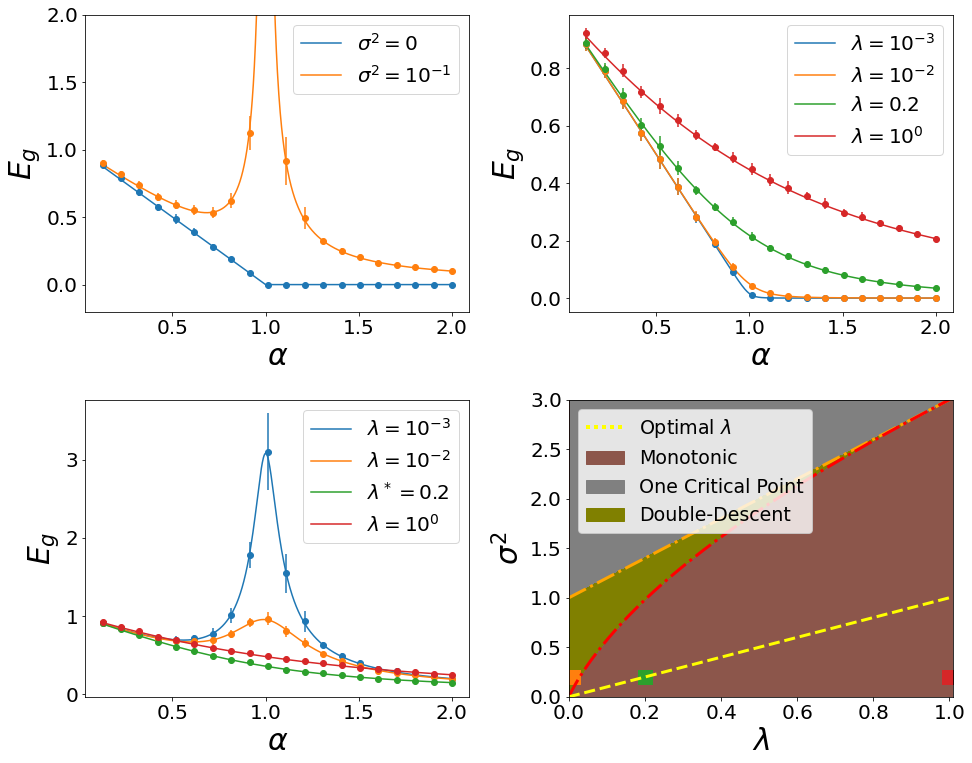

In [6]:
lamb_grid = np.linspace(0.0,1.01, 100)
sigma2_grid = np.linspace(0,2, 100)

def Noise_tilde(alpha_arr):
    noise_var = np.zeros(len(alpha_arr))
    
    for i, alpha in enumerate(alpha_arr):
        if alpha < 2:
            noise_var[i] = 2*alpha-1
        elif alpha > 2:
            noise_var[i] = ker_sim.noise(alpha)
    return noise_var

plt.rcParams.update({'font.size': 20})
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,11))
fontsize = '30'

phase = np.load(dir_phase, allow_pickle = True)
X, Y, Z, levels, alpha, lamb, cut, sigma = [phase['arr_'+str(i)] for i in range(len(phase.files))]


cs=ax4.contourf(X, Y, Z, levels, colors=['tab:brown', 'grey','C7', 'olive'])
ax4.plot(lamb,2*lamb+1,'r-.',color='orange'
         ,linewidth='3')
ax4.plot(lamb[:cut],ker_sim.noise(lamb+1)[:cut],'-.',color='red'
         ,linewidth='3')
ax4.plot(lamb,lamb,'--',color='yellow'
         ,linewidth='3')

ax4.set(xlim=(0, 1.5), ylim=(0, 4))
ax4.set_xlabel("${\\lambda}$",fontsize=fontsize)
ax4.set_ylabel("$\\tilde{\sigma}_{l}^2$",fontsize=fontsize)

ax4.scatter([0.001],[0.2], s=100, marker='s', color = 'C0')
ax4.scatter([0.01],[0.2], s=200, marker = 's', color = 'C1')
ax4.scatter([0.2],[0.2], s=200, marker = 's', color = 'C2')
ax4.scatter([1],[0.2], s=200, marker = 's', color = 'C3')
# ax4.plot(lamb_grid, 0.2*np.ones(len(lamb_grid)) , '--', color = 'black')
ax4.set_xlabel(r'$\lambda$', fontsize =fontsize)
ax4.set_ylabel(r'$\sigma^2$', fontsize =fontsize)
ax4.set_xlim([0, np.amax(lamb_grid)])
ax4.set_ylim([0,3])
proxy = [plt.Line2D([0], [0], color='yellow', lw=4, label='Line',dashes=[1,1,1,1])]
pc = [cs.collections[0], cs.collections[1], cs.collections[3]]
for p in pc:
    proxy += [plt.Rectangle((0,0),1,1,color = p.get_facecolor()[0])]

ax4.legend(proxy, ['Optimal $\lambda$', "Monotonic", 
                   "One Critical Point", "Double-Descent"],loc='upper left', bbox_to_anchor=(0.00, 1), fontsize = 19)

colors = ['C0','C1','C2','C3']

for i, sigma in enumerate(sigmavals):
  ax1.errorbar(pvals/N, no_reg_expt[i], no_reg_std[i], fmt='o', color = colors[i])

ax1.plot(ptheory/N, no_reg_theory[0] , label = r'$\sigma^2 = 0$', color = colors[0])
ax1.plot(ptheory/N, no_reg_theory[1] , label = r'$\sigma^2 = 10^{-1}$', color = colors[1])

ax1.legend()
ax1.set_xlabel(r'$\alpha$', fontsize = fontsize)
ax1.set_ylabel(r'$E_g$', fontsize = fontsize)
ax1.set_ylim([-0.2,2])

for i, lamb in enumerate(lamb_vals):
  ax2.errorbar(pvals/N, no_noise_expt[i], no_noise_std[i], fmt='o', color = colors[i])
  if lamb == 0.2:
    ax2.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = %0.1f$' % lamb, color = colors[i])
  else:
    ax2.plot(ptheory/N, no_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)), color = colors[i])
ax2.legend()
ax2.set_xlabel(r'$\alpha$', fontsize = fontsize)
ax2.set_ylabel(r'$E_g$', fontsize = fontsize)

for i, lamb in enumerate(lamb_vals):
  ax3.errorbar(pvals/N, reg_noise_expt[i], reg_noise_std[i], fmt='o', color = colors[i])
  if lamb == 0.2:
    ax3.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda^*  = %0.1f$' % lamb, color = colors[i])
  else:
    ax3.plot(ptheory/N, reg_noise_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)), color = colors[i])

ax3.legend()
ax3.set_xlabel(r'$\alpha$', fontsize = fontsize)
ax3.set_ylabel(r'$E_g$', fontsize = fontsize)

plt.tight_layout()
if save_data:
  plt.savefig(save_dir + 'Figure3.pdf')

plt.show()

# Out-of-RKHS Case

In [7]:
## With same parameters as above but target has extra
## %20 more modes out-of-RKHS.
## Hence the irreducible error is 0.2.
dN = int(N*0.2)
lamb = 0.01
num_repeats = 50

pvals = np.linspace(100,4*N,num = 20).astype('int')
errs = perceptron_expt(pvals, N, sigma = 0, lamb = lamb, num_repeats=num_repeats, dN = dN)
ptheory = np.linspace(100, 4*N, num = 1000)
theory_errs = theory(ptheory/N, 0, lamb, out_var = dN/N)

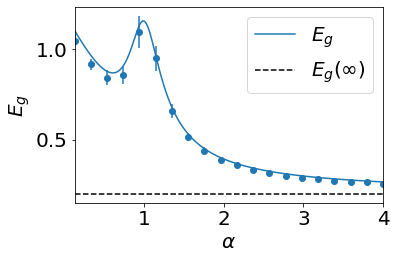

In [8]:
plt.errorbar(pvals/N, np.mean(errs,axis =1), np.std(errs,axis=1), fmt = 'o', color = 'C0')
plt.plot(ptheory/N, theory_errs, label = '$E_g$', color = 'C0')
plt.plot(ptheory/N, dN/N * np.ones(len(ptheory)) , '--', color = 'black', label = '$E_g(\infty)$')
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$E_g$', fontsize=20)
plt.tight_layout()
plt.xlim([pvals[0]/N,4])
plt.legend()
if save_data:
  plt.savefig(save_dir + 'Out-of-RKHS_Bandlimited_Regression.pdf')
plt.show()

# Bias-Variance Decomposition

In [9]:
def perceptron_bias_var(pvals, N, lamb = 0.25, sigma = 0, num_repeats=5, K=5, dN = 0):
  bias = np.zeros((len(pvals), num_repeats))
  variance = np.zeros((len(pvals), num_repeats))

  for i,p in enumerate(pvals):
    key = random.PRNGKey(1)
    for j in range(num_repeats):
      key, teach = random.split(key, 2)
      w_teach = 1/np.sqrt(N) * random.normal(teach, (N + dN,))
      w_avg = np.zeros(N+dN)
      all_w = np.zeros((K,N+dN))
      for k in range(K):
        key, train, test, noise = random.split(key, 4)
        X_tr = random.normal(train, (p,N+dN))
        X_te = random.normal(test, (5000, N + dN))
        y = X_tr @ w_teach
        y = y + sigma * random.normal(noise, (p,))
        noise,_ = random.split(noise) 
        y_true = X_te @ w_teach
        X_tr = X_tr[:,0:N]
        X_te = X_te[:,0:N]
        # assume lamb > 0
        w_hat = X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T + N*lamb*jnp.eye(p)) @ y
        all_w[k,:] = all_w[k,:] + w_hat
      bias[i,j] = np.sum((w_teach - all_w.mean(axis=0))**2)
      variance[i,j] = np.var( all_w, axis = 0 ).sum()
  return bias, variance

def theory_bias_var(alpha, sigma, lamb, out_var = 0):
  z = 0.5 * ( 1+lamb - alpha + np.sqrt( (1+lamb - alpha)**2 + 4*lamb*alpha ) )
  bias = z**2/(z+alpha)**2
  Eg = theory(alpha, sigma, lamb, out_var)
  var = Eg - bias
  return bias, var

In [10]:
lamb = 1e-4
N = 500
pvals = np.linspace(10,2*N,num = 12).astype('int')
ptheory = np.linspace(10, 2*N, num = 1000)
sigma_noise = 0.2
all_errs = []
num_repeats=15
K = 20

bias_noise, variance_noise = perceptron_bias_var(pvals, N, sigma=sigma_noise, lamb = lamb, num_repeats=num_repeats, K=K)
tbias_noise, tvar_noise = theory_bias_var(ptheory/N, sigma_noise, lamb, out_var = 0)
errs_noise = perceptron_expt(pvals, N, lamb = lamb, sigma = sigma_noise, num_repeats=num_repeats, dN = 0)

lamb = 1e-4
pvals = np.linspace(10,2*N,num = 12).astype('int')
ptheory = np.linspace(10, 2*N, num = 1000)
sigma_nonoise = 0.0
all_errs = []
num_repeats=15
K = 20

bias_nonoise, variance_nonoise = perceptron_bias_var(pvals, N, sigma= sigma_nonoise, lamb = lamb, num_repeats=num_repeats, K=K)
tbias_nonoise, tvar_nonoise = theory_bias_var(ptheory/N, sigma_nonoise, lamb, out_var = 0)
errs_nonoise = perceptron_expt(pvals, N, lamb = lamb, sigma = sigma_nonoise, num_repeats=num_repeats, dN = 0)

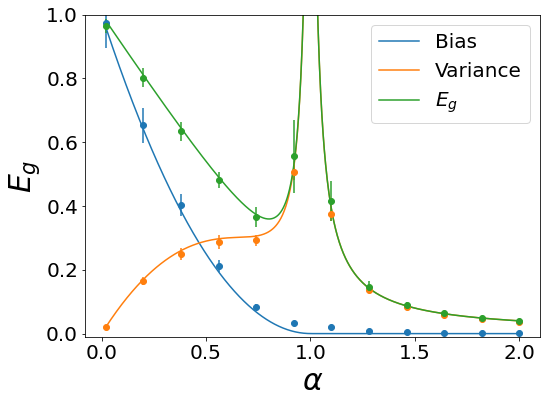

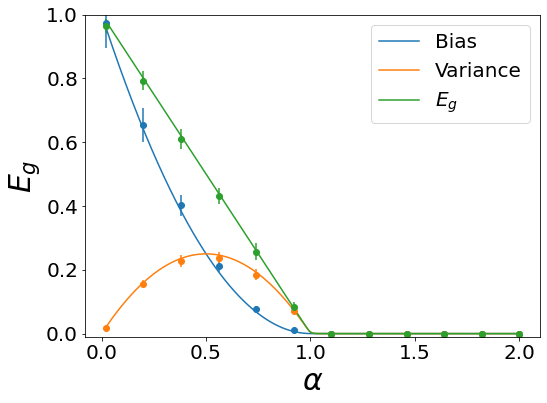

In [11]:
fontsize = '30'
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 20})
plt.errorbar(pvals/N, bias_noise.mean(axis= 1), bias_noise.std(axis=1), fmt='o', color = 'C0')
plt.plot(ptheory/N, tbias_noise, color = 'C0', label = 'Bias')
plt.errorbar(pvals/N, variance_noise.mean(axis = 1),variance_noise.std(axis = 1), fmt='o', color = 'C1')
plt.plot(ptheory/N, tvar_noise, color = 'C1', label = 'Variance')
plt.errorbar(pvals/N, errs_noise.mean(axis = 1), errs_noise.std(axis = 1), fmt ='o', color = 'C2')
plt.plot(ptheory/N, tbias_noise+tvar_noise, color = 'C2', label = r'$E_g$')
plt.xlabel(r'$\alpha$', fontsize=fontsize)
plt.ylabel(r'$E_g$', fontsize=fontsize)
plt.legend()
plt.ylim([-0.01,1])
plt.tight_layout()
if save_data: plt.savefig(save_dir + 'bias_variance_sigma_%0.2f.pdf' % (sigma_noise))
plt.show()

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 20})
plt.errorbar(pvals/N, bias_nonoise.mean(axis= 1), bias_nonoise.std(axis=1), fmt='o', color = 'C0')
plt.plot(ptheory/N, tbias_nonoise, color = 'C0', label = 'Bias')
plt.errorbar(pvals/N, variance_nonoise.mean(axis = 1),variance_nonoise.std(axis = 1), fmt='o', color = 'C1')
plt.plot(ptheory/N, tvar_nonoise, color = 'C1', label = 'Variance')
plt.errorbar(pvals/N, errs_nonoise.mean(axis = 1), errs_nonoise.std(axis = 1), fmt ='o', color = 'C2')
plt.plot(ptheory/N, tbias_nonoise+tvar_nonoise, color = 'C2', label = r'$E_g$')
plt.xlabel(r'$\alpha$', fontsize=fontsize)
plt.ylabel(r'$E_g$', fontsize=fontsize)
plt.legend()
plt.ylim([-0.01,1])
plt.tight_layout()
if save_data: plt.savefig(save_dir + 'bias_variance_sigma_%0.2f.pdf' % (sigma_nonoise))
plt.show()

# Average Estimator

In [12]:
import numpy as np
import numpy as npo
import matplotlib.pyplot as plt
import math

num_k = 20
pvals = [0, 12, 28, 40]
P = 1000
x_fine = np.linspace(-np.pi, np.pi, P)

cos_features = np.array([np.cos((k+1) * x_fine) for k in range(num_k)])

target = np.exp(4 * np.cos(x_fine)) / np.exp(4)
target_mean = np.mean(target)
target -= target_mean
target = 2 / P * cos_features.T @ cos_features @ target

def kernel(x, xp):
    K = np.zeros((x.shape[0], xp.shape[0]))
    diff = np.outer(np.ones(x.shape[0]), xp) - np.outer(x, np.ones(xp.shape[0]))
    for k in range(1, num_k+1):
        K += np.cos(k * diff)
    return K

lamb = 1e-14
all_mean = []
all_std = []
rep_num = 500
sigma = 0 #0.005 / len(x_fine)

yhat = npo.zeros ((len(pvals), rep_num, len(x_fine)))
ytheory = npo.zeros ((len(pvals), len(x_fine)))
for i, p in enumerate (pvals):
  ytheory[i] = p/(2*num_k)*target
  for j in range (rep_num):
    xi = npo.random.uniform(-np.pi, np.pi, p)
    yi = np.exp(4 * np.cos(xi)) / np.exp(4) - target_mean
    yi += sigma * npo.random.standard_normal(p)
    K = kernel(xi, xi)
    Ki = kernel(x_fine, xi)
    alpha = np.linalg.solve(K + lamb*np.eye(p), yi)
    yhat[i,j] = Ki @ alpha

all_mean = yhat.mean(axis = 1)
all_std = yhat.std(axis = 1)

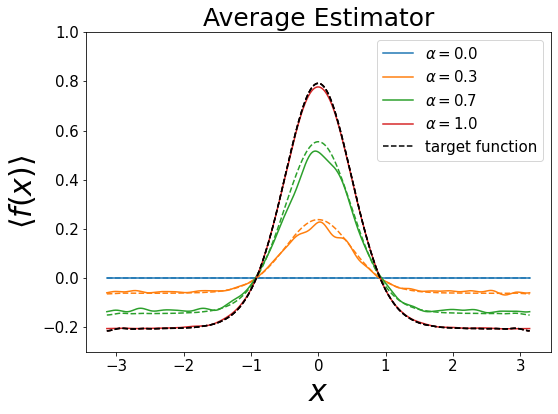

In [13]:
fontsize = '30'
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
for i, y in enumerate(all_mean):
    plt.plot(x_fine, y, label = r'$\alpha =%0.1f $'% (0.5 * pvals[i] / num_k), color = 'C%d'% i)
    plt.plot(x_fine, ytheory[i], '--', color = 'C%d'% i)
    #plt.fill_between(x_fine, y - all_std[i], y + all_std[i], alpha = 0.2, color = 'C%d'% i)

plt.plot(x_fine, np.minimum(1, 0.5 * pvals [i]/num_k) * target, '--', color = 'black')
plt.plot(x_fine, target, '--', color = 'black', label='target function')
plt.legend()
plt.xlabel(r'$ x $', fontsize = fontsize)
plt.ylabel(r'$\left <f(x)\right> $', fontsize = fontsize)
plt.title(r'Average Estimator', fontsize = '25')
plt.ylim([-0.3, 1])
plt.tight_layout ()
if save_data: plt.savefig(save_dir+'average_estimator_K_%d_sigma_%.2f.pdf'% (rep_num, sigma * len (x_fine)))
plt.show()